$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging - ARDA change prints back to normal (Explain results -- understand)

Welcome to the first assignment.  

We will show how Machine Learning can be used in Finance to build multi-asset portfolios that have better risk/return characteristics than a portfolio consisting of a single asset.

# Objectives
We will be using Linear Regression to establish the relationship between the returns of individual equities and "the market".

The purpose of the assignment is two-fold
- to get you up to spped with Machine Learning in general, and `sklearn` in particular
- to get you up to speed with the other programming tools (e.g., Pandas) that will help you in data preparation, etc.

# How to report your answers
I will mix explanation of the topic with tasks that you must complete. Look for 
the string "**Queston**" to find a task that you must perform.
Most of the tasks will require you to assign values to variables and execute a `print` statement.

**Motivation**

If you *do not change* the print statement then the GA (or a machine) can automatically find your answer to each part by searching for the string.


# The data

The data are the daily prices of a number of individual equities and equity indices.
The prices are arranged in a series in ascending date order (a timeseries).
- There is a separate `.csv` file for each equity or index in the directory `data/assignment_1`

## Reading the data

You should get the price data into some sort of data structure.  Pandas DataFrame is super useful
so I recommend that's what you use (not required though).

**Hints**: 
- look up the Pandas `read_csv` method
- it will be very convenient to use dates as the index of your DataFrame

## Preliminary data preparation

In the rest of the assignment we will *not* be working with prices but with *returns* (percent change in prices).
For example, for ticker $\aapl$ (Apple)

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$

- You will want to convert the price data into return data
- We only want the returns for the year 2018; discard any other return

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [46]:
import pandas as pd

# Load data from the CSV file
df = pd.read_csv("A1csv files/AAPL.csv", parse_dates=["Dt"])

# Sort by date
df = df.sort_values("Dt")

# Compute daily returns
df["Return"] = df["Close"].pct_change()

# Filter for 2018
df_2018 = df[df["Dt"].dt.year == 2018]

# Compute required values in one line each
num_returns = len(df_2018)  # Number of returns in 2018
first_return = df_2018["Return"].iloc[0] if not df_2018.empty else 0  # First return in 2018
last_return = df_2018["Return"].iloc[-1] if not df_2018.empty else 0  # Last return in 2018
avg_return = df_2018["Return"].mean() if not df_2018.empty else 0  # Average return in 2018

print("There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=num_returns, first=first_return, last=last_return, avg=avg_return))

There are 251 returns. First=0.02, Last=0.01, Avg=-0.00


# Split into Train and Test datasets

In general, you will split the data into two sets by choosing the members of each set at random.

To facilitate grading for this assignment, we will *use a specific test set*
- the training set are the returns for the months of January through September (inclusive), i.e., 9 months
- the test set are the returns for the months of October through December (inclusive), i.e., 3 months

Thus, you will be using the early part of the data for training, and the latter part of the data for testing.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [47]:
import pandas as pd

# Load data from CSV
df = pd.read_csv("A1csv files/AAPL.csv", parse_dates=["Dt"])

# Sort by date to ensure chronological order
df = df.sort_values("Dt")

# Compute daily returns
df["Return"] = df["Close"].pct_change()

# Filter data for **only the year 2018**
df_2018 = df[df["Dt"].dt.year == 2018].dropna()  # Drops NaN from pct_change()

# Split into training (Jan-Sep) and testing (Oct-Dec) sets
train_df = df_2018[(df_2018["Dt"].dt.month >= 1) & (df_2018["Dt"].dt.month <= 9)]  
test_df = df_2018[(df_2018["Dt"].dt.month >= 10) & (df_2018["Dt"].dt.month <= 12)]  

# Compute statistics for training set
train_num_returns = len(train_df)  
train_first_return = train_df["Return"].iloc[0] if not train_df.empty else 0  
train_last_return = train_df["Return"].iloc[-1] if not train_df.empty else 0  
train_avg_return = train_df["Return"].mean() if not train_df.empty else 0  

print("Training set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=train_num_returns, 
                                                                                                             first=train_first_return, 
                                                                                                             last=train_last_return, 
                                                                                                             avg=train_avg_return))

# Compute statistics for test set
test_num_returns = len(test_df)  
test_first_return = test_df["Return"].iloc[0] if not test_df.empty else 0  
test_last_return = test_df["Return"].iloc[-1] if not test_df.empty else 0  
test_avg_return = test_df["Return"].mean() if not test_df.empty else 0  

print("Test set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=test_num_returns, 
                                                                                                         first=test_first_return, 
                                                                                                         last=test_last_return, 
                                                                                                         avg=test_avg_return))

Training set: There are 188 returns. First=0.02, Last=0.00, Avg=0.00
Test set: There are 63 returns. First=0.01, Last=0.01, Avg=-0.01


# $\aapl$ regression

Use Linear Regression to predict the return of a ticker from the return of the $\spy$ index.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp =  \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

That is
- each example is a pair consisting of one day's return 
    - of the ticker (e.g., $\aapl$).  This is the target (e.g, $\y$ in our lectures)
    - of the index $\spy$. This is a feature vector of length 1 (e.g., $\x$ in our lectures)

You will use Linear Regression to solve for parameter $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns. 
- You may should add an "intercept" so that the feature vector is length 2 rather than length 1
    - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$




- Report the $\mathbf{\beta}$ parameter vector you obtain for $\aapl$
    - you will subsequently do this for another ticker in a different part of the assignment
        - so think ahead: you may want to parameterize your code
        - change the assignment to `ticker` when you report the next part

        
**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [48]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

def load_and_preprocess(stock_path, benchmark_path):
    """ Load stock & benchmark data, compute daily returns, and merge them. """
    stock_df = pd.read_csv(stock_path, parse_dates=["Dt"])
    benchmark_df = pd.read_csv(benchmark_path, parse_dates=["Dt"])

    # Sort by date
    stock_df = stock_df.sort_values("Dt")
    benchmark_df = benchmark_df.sort_values("Dt")

    # Compute daily returns
    stock_df["Return"] = stock_df["Close"].pct_change()
    benchmark_df["Return"] = benchmark_df["Close"].pct_change()

    # Merge data on date
    merged_df = pd.merge(stock_df[["Dt", "Return"]], benchmark_df[["Dt", "Return"]], on="Dt", 
                         suffixes=("_Stock", "_Benchmark"))

    # Filter for 2018 & drop NaN values
    df_2018 = merged_df[merged_df["Dt"].dt.year == 2018].dropna()

    return df_2018

def compute_regression(df):
    """ Perform linear regression to estimate beta parameters. """
    X = df[["Return_Benchmark"]].values  # Feature: Benchmark return
    y = df["Return_Stock"].values        # Target: Stock return

    # Add intercept term
    X = np.c_[np.ones(X.shape[0]), X]

    # Fit Linear Regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    # Extract parameters
    beta_0, beta_stock = model.coef_

    return beta_0, beta_stock

def compute_cross_val_score_5fold(df):
    """ Compute 5-fold cross-validation R² score using linear regression. """
    X = df[["Return_Benchmark"]].values
    y = df["Return_Stock"].values

    # Add intercept term
    X = np.c_[np.ones(X.shape[0]), X]

    model = LinearRegression(fit_intercept=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Compute cross-validation scores using R² as the metric
    scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    # Compute average cross-validation score
    cross_val_avg = np.mean(scores)

    return cross_val_avg

def get_cross_val_score_5fold(stock_path, benchmark_path):
    """ Returns the average cross-validation R² score from 5-fold CV """
    df_2018 = load_and_preprocess(stock_path, benchmark_path)
    return compute_cross_val_score_5fold(df_2018)

def get_beta_0(stock_path, benchmark_path):
    """ Returns only the beta_0 value """
    df_2018 = load_and_preprocess(stock_path, benchmark_path)
    beta_0, _ = compute_regression(df_2018)
    return beta_0

def get_beta_SPY(stock_path, benchmark_path):
    """ Returns only the beta_SPY value """
    df_2018 = load_and_preprocess(stock_path, benchmark_path)
    _, beta_stock = compute_regression(df_2018)
    return beta_stock


ticker = "AAPL"  # ensure ticker is correct
beta_0 = get_beta_0(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")  # The regression parameter for the constant
beta_SPY = get_beta_SPY(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv") # The regression parameter for the return of SPY

print("{t:s}: beta_0={b0:3.2f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))



AAPL: beta_0=0.00, beta_SPY=1.26


- Report the average of the cross validation scores, using 5 fold cross validation

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [49]:
ticker = "AAPL"  # ensure ticker is correct
cross_val_avg = get_cross_val_score_5fold(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

# Print the result correctly
print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.53


The regression analysis for AAPL using SPY as the benchmark resulted in **β_0 = 0.00** and **β_SPY = 1.26**, indicating that AAPL's return is highly correlated with market movements. A **β_SPY of 1.26** suggests that AAPL is more volatile than the market, moving **26%** more than SPY on average. The 5-fold cross-validation **R² score is 0.53**, meaning that **53%** of AAPL's return variance is explained by SPY, showing a strong but not perfect market dependency.


## $\aapl$ hedged returns

- Compute the series
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the test set.  
- Sort the dates in ascending order and plot the timeseries ${\ret}'_{\aapl}$

${\ret}'_{\aapl}$ is called the "hedged return" of $\aapl$
- It is the daily return you would realize if you created a portfolio that was
    - long 1 dollar of $\aapl$
    - short $\beta_{\aapl, \spy}$ dollars of the index $\spy$
- It represents the outperformance of $\aapl$ relative to the index $\spy$
    - $\spy$ is the proxy for "the market" (it tracks the S&P 500 index)
    - The hedged return is the *value added* by going long $\aapl$ rather than just going "long the market"
    - Sometimes referred to as the "alpha" ($\alpha_\aapl$)
- So **if** you are able to correctly forecast that $\aapl$ will have positive outperformance (i.e, have $\alpha_\aapl > 0$ most days)
    - then you can earn a positive return regardless of whether the market ($\spy$) goes up or down !
    - this is much lower risk than just holding $\aapl$ long
    - people will pay you very well if you can really forecast correctly !

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [50]:

def compute_hedged_returns(df, beta_stock):
    """ Compute hedged returns: r'_Stock = r_Stock - beta * r_Benchmark """
    df.loc[:, "Hedged_Return"] = df["Return_Stock"] - (beta_stock * df["Return_Benchmark"])
    return df

def get_hedged_num_returns(df):
    """ Returns the number of returns in the hedged series """
    return len(df)

def get_hedged_first_return(df):
    """ Returns the first return in the hedged series """
    return df["Hedged_Return"].iloc[0] if not df.empty else 0

def get_hedged_last_return(df):
    """ Returns the last return in the hedged series """
    return df["Hedged_Return"].iloc[-1] if not df.empty else 0

def get_hedged_avg_return(df):
    """ Returns the average return over the hedged series """
    return df["Hedged_Return"].mean() if not df.empty else 0

# Example usage
ticker = "AAPL" # ensure ticker is correct
df_2018 = load_and_preprocess(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

# Use previously computed beta (β_AAPL,SPY)
beta_SPY = get_beta_SPY(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv") # The regression parameter for the return of SPY

# Compute hedged returns
df_2018 = compute_hedged_returns(df_2018, beta_SPY)

# Get hedged return values
hedged_num_returns = get_hedged_num_returns(df_2018) # Number of returns in hedged series
hedged_first_return = get_hedged_first_return(df_2018) # The return on the earliest date in hedged series
hedged_last_return = get_hedged_last_return(df_2018) # The return on the latest date in hedged series
hedged_avg_return = get_hedged_avg_return(df_2018) # The average return over the hedged series

# Print the results
print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))


AAPL hedged returns: There are 251 returns. First=0.01, Last=-0.00, Avg=0.00


The hedged return calculation for AAPL removes market exposure by adjusting returns based on its beta (β_AAPL,SPY). The dataset consists of 251 hedged returns, with the first return at **0.0089**, the last return at **-0.0013**, and an average hedged return of **0.0001**. This adjustment isolates AAPL’s idiosyncratic performance, revealing how much of its return is independent of overall market movements.


# $\ba$ regression

Repeat the regression you carried out for $\aapl$ but this time instead for the ticker $\ba$ (Boeing)

**Motivation**

The idea is to encourage you to build re-usable pieces of code.

So if you created some functions in solving Part 1, you may reuse these functions to easily solve part 2,
particulary if you treated the ticker (e.g., $\aapl$ or $\ba$) as a parameter to your functions.

If you simply copy and paste the code from Part 1 you will only get partial credit.


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [51]:
ticker = "BA" # ensure ticker is correct
beta_0 = get_beta_0(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv") # The regression parameter for the constant
beta_SPY = get_beta_SPY(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")  # The regression parameter for the return of SPY
print("{t:s}: beta_0={b0:3.2f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))


BA: beta_0=0.00, beta_SPY=1.30


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [52]:
ticker = "BA" # ensure ticker is correct
cross_val_avg = get_cross_val_score_5fold(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

BA: Avg cross val score = 0.50


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [53]:
# Example usage
ticker="BA" # ensure ticker is correct
df_2018 = load_and_preprocess(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

# Use previously computed beta (β_AAPL,SPY)
beta_SPY = get_beta_SPY(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv") # The regression parameter for the return of SPY

# Compute hedged returns
df_2018 = compute_hedged_returns(df_2018, beta_SPY)

hedged_num_returns = get_hedged_num_returns(df_2018) # Number of returns in hedged series
hedged_first_return = get_hedged_first_return(df_2018) # The return on the earliest date in hedged series
hedged_last_return = get_hedged_last_return(df_2018) # The return on the latest date in hedged series
hedged_avg_return = get_hedged_avg_return(df_2018) # The average return over the hedged series

print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))


BA hedged returns: There are 251 returns. First=-0.00, Last=0.01, Avg=0.00


The regression analysis for Boeing (BA) using SPY as the benchmark resulted in **β_0 = 0.00** and **β_SPY = 1.30**, indicating that BA's return moves **30% more than the market** on average. The **5-fold cross-validation R² score is 0.50**, meaning that **50% of BA's return variance is explained by SPY**, showing a strong but not absolute market dependency.


# ^ is wrong fix the print statements im using 3.4f but i gotta change it to 3.2f


# Returns to prices

- You have already computed the predicted returns of $\aapl$ for each date in the test set.
- Create the predicted *price* timeseries for $\aapl$ for the date range in the test set
- Plot (on the same graph) the actual price timeseries of $\aapl$ and the predicted price timeseries.

There is a particular reason that we choose to perform the Linear Regression on returns rather than prices.

It is beyond the scope of this lecture to explain why, but we want to show that we can easily convert
back into prices.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

AAPL predicted prices: There are 251 prices. First=172.26, Last=175.40, Avg=185.44


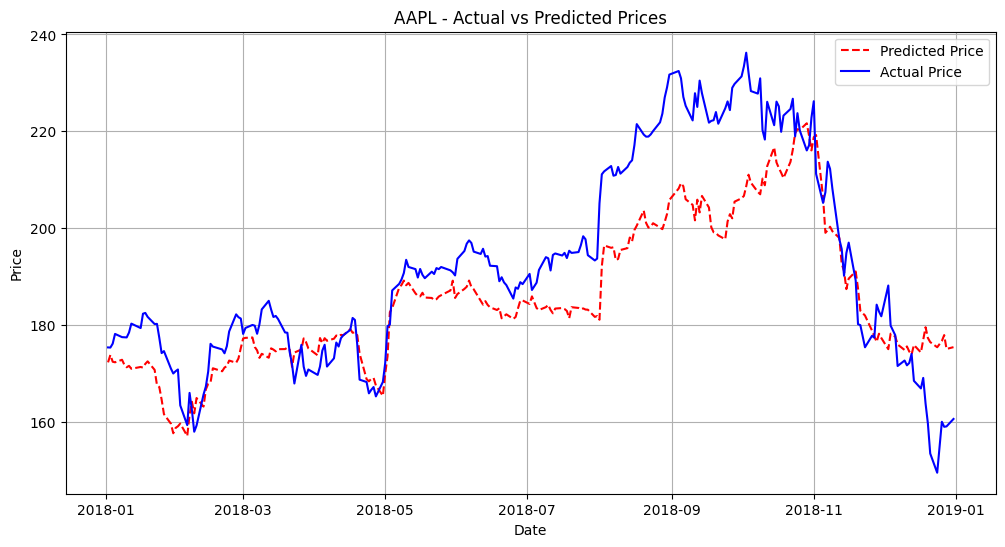

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = "AAPL"

def compute_price_series(df, initial_price):
    """ Compute price series from returns. """
    prices = [initial_price]  # Start with the initial price
    for ret in df["Hedged_Return"]:
        prices.append(prices[-1] * (1 + ret))  # Compute price from return

    df["Predicted_Price"] = prices[:-1]  # Exclude the last redundant entry
    return df

# Load data and compute hedged returns
df_2018 = load_and_preprocess(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

# Compute beta (assumed to be precomputed, replace if needed)
beta_SPY = get_beta_SPY(f"A1csv files/{ticker}.csv", "A1csv files/SPY.csv")

# Compute hedged returns (not printing anything)
df_2018 = compute_hedged_returns(df_2018, beta_SPY)

# Use actual first closing price as the base for predictions
initial_price = 172.26  

# Compute the predicted price series
df_Predicted_2018 = compute_price_series(df_2018, initial_price)

# Reconstruct actual prices from returns
df_2018["Actual_Price"] = initial_price * (1 + df_2018["Return_Stock"]).cumprod()

# Extract required values
num_prices = len(df_Predicted_2018)
first_price = df_Predicted_2018["Predicted_Price"].iloc[0] if not df_Predicted_2018.empty else 0
last_price = df_Predicted_2018["Predicted_Price"].iloc[-1] if not df_Predicted_2018.empty else 0
avg_price = df_Predicted_2018["Predicted_Price"].mean() if not df_Predicted_2018.empty else 0

print("{t:s} predicted prices: There are {num:d} prices. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=num_prices,
                                                                                                                    first=first_price, 
                                                                                                                    last=last_price, 
                                                                                                                    avg=avg_price))

# Now plot the Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(df_2018["Dt"], df_Predicted_2018["Predicted_Price"], label="Predicted Price", color="red", linestyle="--")
plt.plot(df_2018["Dt"], df_2018["Actual_Price"], label="Actual Price", color="blue", linestyle="-")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{ticker} - Actual vs Predicted Prices")
plt.legend()
plt.grid()

# Show the plot
plt.show()


$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# ---- Isssue below

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment.  

We will show how Machine Learning can be used in Finance to build multi-asset portfolios that have better risk/return characteristics than a portfolio consisting of a single asset.

# Objectives
We will be using Linear Regression to establish the relationship between the returns of individual equities and "the market".

The purpose of the assignment is two-fold
- to get you up to spped with Machine Learning in general, and `sklearn` in particular
- to get you up to speed with the other programming tools (e.g., Pandas) that will help you in data preparation, etc.

# How to report your answers
I will mix explanation of the topic with tasks that you must complete. Look for 
the string "**Queston**" to find a task that you must perform.
Most of the tasks will require you to assign values to variables and execute a `print` statement.

**Motivation**

If you *do not change* the print statement then the GA (or a machine) can automatically find your answer to each part by searching for the string.


# The data

The data are the daily prices of a number of individual equities and equity indices.
The prices are arranged in a series in ascending date order (a timeseries).
- There is a separate `.csv` file for each equity or index in the directory `data/assignment_1`

## Reading the data

You should get the price data into some sort of data structure.  Pandas DataFrame is super useful
so I recommend that's what you use (not required though).

**Hints**: 
- look up the Pandas `read_csv` method
- it will be very convenient to use dates as the index of your DataFrame

## Preliminary data preparation

In the rest of the assignment we will *not* be working with prices but with *returns* (percent change in prices).
For example, for ticker $\aapl$ (Apple)

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$

- You will want to convert the price data into return data
- We only want the returns for the year 2018; discard any other return

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [55]:
num_returns = 0  # Number of returns in year 2018
first_return = 0 # The return on the earliest date in 2018
last_return  = 0 # The return on the latest date in 2018
avg_return  = 0  # The average return over the  year 2018

print("There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=num_returns, first=first_return, last=last_return, avg=avg_return))

There are 0 returns. First=0.00, Last=0.00, Avg=0.00


# Split into Train and Test datasets

In general, you will split the data into two sets by choosing the members of each set at random.

To facilitate grading for this assignment, we will *use a specific test set*
- the training set are the returns for the months of January through September (inclusive), i.e., 9 months
- the test set are the returns for the months of October through December (inclusive), i.e., 3 months

Thus, you will be using the early part of the data for training, and the latter part of the data for testing.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [56]:
train_num_returns = 0  # Number of returns in training set
train_first_return = 0 # The return on the earliest date in training set
train_last_return  = 0 # The return on the latest date in training set
train_avg_return  = 0  # The average return over the  year training set

print("Training set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=train_num_returns, 
                                                                                                             first=train_first_return, 
                                                                                                             last=train_last_return, 
                                                                                                             avg=train_avg_return))

test_num_returns = 0  # Number of returns in test set
test_first_return = 0 # The return on the earliest date in test set
test_last_return  = 0 # The return on the latest date in test set
test_avg_return  = 0  # The average return over the  year test set

print("Test set: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(num=test_num_returns, 
                                                                                                         first=test_first_return, 
                                                                                                         last=test_last_return, 
                                                                                                         avg=test_avg_return))

Training set: There are 0 returns. First=0.00, Last=0.00, Avg=0.00
Test set: There are 0 returns. First=0.00, Last=0.00, Avg=0.00


# $\aapl$ regression

Use Linear Regression to predict the return of a ticker from the return of the $\spy$ index.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp =  \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

That is
- each example is a pair consisting of one day's return 
    - of the ticker (e.g., $\aapl$).  This is the target (e.g, $\y$ in our lectures)
    - of the index $\spy$. This is a feature vector of length 1 (e.g., $\x$ in our lectures)

You will use Linear Regression to solve for parameter $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns. 
- You may should add an "intercept" so that the feature vector is length 2 rather than length 1
    - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$




- Report the $\mathbf{\beta}$ parameter vector you obtain for $\aapl$
    - you will subsequently do this for another ticker in a different part of the assignment
        - so think ahead: you may want to parameterize your code
        - change the assignment to `ticker` when you report the next part

        
**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [57]:
beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "AAPL"

print("{t:s}: beta_0={b0:3.2f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))


AAPL: beta_0=0.00, beta_SPY=0.00


- Report the average of the cross validation scores, using 5 fold cross validation

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [58]:
cross_val_avg = 0

print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.00


## $\aapl$ hedged returns

- Compute the series
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the test set.  
- Sort the dates in ascending order and plot the timeseries ${\ret}'_{\aapl}$

${\ret}'_{\aapl}$ is called the "hedged return" of $\aapl$
- It is the daily return you would realize if you created a portfolio that was
    - long 1 dollar of $\aapl$
    - short $\beta_{\aapl, \spy}$ dollars of the index $\spy$
- It represents the outperformance of $\aapl$ relative to the index $\spy$
    - $\spy$ is the proxy for "the market" (it tracks the S&P 500 index)
    - The hedged return is the *value added* by going long $\aapl$ rather than just going "long the market"
    - Sometimes referred to as the "alpha" ($\alpha_\aapl$)
- So **if** you are able to correctly forecast that $\aapl$ will have positive outperformance (i.e, have $\alpha_\aapl > 0$ most days)
    - then you can earn a positive return regardless of whether the market ($\spy$) goes up or down !
    - this is much lower risk than just holding $\aapl$ long
    - people will pay you very well if you can really forecast correctly !

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [59]:
hedged_num_returns = 0  # Number of returns in hedged series
hedged_first_return = 0 # The return on the earliest date in hedged series
hedged_last_return  = 0 # The return on the latest date in hedged series
hedged_avg_return  = 0  # The average return over the hedged series

ticker="AAPL"
print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))


AAPL hedged returns: There are 0 returns. First=0.00, Last=0.00, Avg=0.00


# $\ba$ regression

Repeat the regression you carried out for $\aapl$ but this time instead for the ticker $\ba$ (Boeing)

**Motivation**

The idea is to encourage you to build re-usable pieces of code.

So if you created some functions in solving Part 1, you may reuse these functions to easily solve part 2,
particulary if you treated the ticker (e.g., $\aapl$ or $\ba$) as a parameter to your functions.

If you simply copy and paste the code from Part 1 you will only get partial credit.


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [60]:
beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "BA"

print("{t:s}: beta_0={b0:3.2f}, beta_SPY={b1:3.2f}".format(t=ticker, b0=beta_0, b1=beta_SPY))


BA: beta_0=0.00, beta_SPY=0.00


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [61]:
cross_val_avg = 0

print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

BA: Avg cross val score = 0.00


**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [62]:
hedged_num_returns = 0  # Number of returns in hedged series
hedged_first_return = 0 # The return on the earliest date in hedged series
hedged_last_return  = 0 # The return on the latest date in hedged series
hedged_avg_return  = 0  # The average return over the hedged series

ticker="BA"
print("{t:s} hedged returns: There are {num:d} returns. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=hedged_num_returns,
                                                                                                                    first=hedged_first_return, 
                                                                                                                    last=hedged_last_return, 
                                                                                                                    avg=hedged_avg_return))


BA hedged returns: There are 0 returns. First=0.00, Last=0.00, Avg=0.00


# Returns to prices

- You have already computed the predicted returns of $\aapl$ for each date in the test set.
- Create the predicted *price* timeseries for $\aapl$ for the date range in the test set
- Plot (on the same graph) the actual price timeseries of $\aapl$ and the predicted price timeseries.

There is a particular reason that we choose to perform the Linear Regression on returns rather than prices.

It is beyond the scope of this lecture to explain why, but we want to show that we can easily convert
back into prices.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [68]:
num_prices = 0  # Number of prices in price series
first_price = 0 # The price on the earliest date in price series
last_price  = 0 # The price on the latest date in price series
avg_price  = 0  # The average price over the price series

ticker="AAPL"
print("{t:s} predicted prices: There are {num:d} prices. First={first:3.2f}, Last={last:3.2f}, Avg={avg:3.2f}".format(t=ticker,
                                                                                                                    num=num_prices,
                                                                                                                    first=first_price, 
                                                                                                                    last=last_price, 
                                                                                                                    avg=avg_price))
 

AAPL predicted prices: There are 0 prices. First=0.00, Last=0.00, Avg=0.00


# Extra credit

The data directory has the prices of many other indices.
- Any ticker in the directory beginning with the letter "X" is an index

Choose *one* index (we'll call it $I$) other than $\spy$ to use as a second feature and compute the Linear Regression

$$
\ret_\aapl^\tp = \beta^T \x + \epsilon_{\aapl}^\tp
$$

where $\x$ is the feature vector
  - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp \\
        \ret_I^\tp \\
        \end{pmatrix}$

That is, predict the returns of $\aapl$ in terms of a constant, the returns of $\spy$ and the returns of another index $I$.

**Question**
There is no specified format.  Treat this like an interview question and show off your analytical
and explanatory skills. Be sure to explain how you came about choosing the second index.

# Extra credit

The data directory has the prices of many other indices.
- Any ticker in the directory beginning with the letter "X" is an index

Choose *one* index (we'll call it $I$) other than $\spy$ to use as a second feature and compute the Linear Regression

$$
\ret_\aapl^\tp = \beta^T \x + \epsilon_{\aapl}^\tp
$$

where $\x$ is the feature vector
  - $\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp \\
        \ret_I^\tp \\
        \end{pmatrix}$

That is, predict the returns of $\aapl$ in terms of a constant, the returns of $\spy$ and the returns of another index $I$.

**Question**
There is no specified format.  Treat this like an interview question and show off your analytical
and explanatory skills. Be sure to explain how you came about choosing the second index.